## Post MVP

There are a few things I want to do:
* Increase my sample size to include more than just 'single family residential' properties. Things like bungalows, mobile homes, and town houses.
* After cleaning the new data, explore new features like property type, location (lat, long), county, and decade built.
* Form new hypotheses and test them. Will need at least one t-test.
* Determine the most useful features for modeling
* Create different models and see how they stack up against my MVP model.

### Getting the new data

* Will need to update the sql query.

In [1]:
import numpy as np 
import pandas as pd
import env
import wrangle
import explore
import model
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

My new query will include homes of type:
* 261	Single Family Residential
* 262	Rural Residence
* 263	Mobile Home
* 264	Townhouse
* 265	Cluster Home
* 268   Row House
* 273   Bungalow
* 275	Manufactured, Modular, Prefabricated Homes
* 276	Patio Home
* 279	Inferred Single Family Residential

In [2]:
zillow_query = """
    SELECT * FROM properties_2017
    LEFT JOIN predictions_2017 ON predictions_2017.parcelid = properties_2017.parcelid
    LEFT JOIN heatingorsystemtype ON heatingorsystemtype.heatingorsystemtypeid = properties_2017.heatingorsystemtypeid
    LEFT JOIN propertylandusetype ON propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
    WHERE (properties_2017.propertylandusetypeid IN (261, 262, 263, 264, 265, 268, 273, 275, 276, 279))
        AND (predictions_2017.transactiondate >= '2017-05-01'
            AND predictions_2017.transactiondate <= '2017-08-31');
"""

In [3]:
zillow_url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/zillow'

In [4]:
#Get the new data
zillow = pd.read_sql(zillow_query, zillow_url)
zillow.head()

id  parcelid  airconditioningtypeid  architecturalstyletypeid  \
0   616260  11721753                    NaN                       NaN   
1  2061546  11289917                    1.0                       NaN   
2  1834372  11705026                    NaN                       NaN   
3  1923117  14269464                    NaN                       NaN   
4   451211  11446756                    NaN                       NaN   

   basementsqft  bathroomcnt  bedroomcnt buildingclasstypeid  \
0           NaN          2.0         3.0                None   
1           NaN          2.0         3.0                None   
2           NaN          1.0         2.0                None   
3           NaN          3.0         4.0                None   
4           NaN          2.0         3.0                None   

   buildingqualitytypeid  calculatedbathnbr  ...  taxdelinquencyyear  \
0                    6.0                2.0  ...                 NaN   
1                    6.0                2.0  ...                15.0   
2                    6.0                1.0  ...                 NaN   
3                    NaN                3.0  ...                 NaN   
4                    6.0                2.0  ...                 NaN   

   censustractandblock    id  parcelid  logerror transactiondate  \
0         6.037220e+13  1018  11721753  0.017785      2017-07-21   
1         6.037901e+13  1248  11289917 -0.362001      2017-06-23   
2         6.037232e+13  1772  11705026 -0.146056      2017-06-30   
3         6.059064e+13  2028  14269464  0.021085      2017-06-01   
4         6.037650e+13  2681  11446756 -0.163064      2017-08-23   

   heatingorsystemtypeid  heatingorsystemdesc  propertylandusetypeid  \
0                    7.0           Floor/Wall                    261   
1                    2.0              Central                    261   
2                    2.0              Central                    261   
3                    NaN                 None                    261   
4                    7.0           Floor/Wall                    261   

         propertylandusedesc  
0  Single Family Residential  
1  Single Family Residential  
2  Single Family Residential  
3  Single Family Residential  
4  Single Family Residential  

[5 rows x 67 columns]

In [5]:
#Take a quick look
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28387 entries, 0 to 28386
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            28387 non-null  int64  
 1   parcelid                      28387 non-null  int64  
 2   airconditioningtypeid         7307 non-null   float64
 3   architecturalstyletypeid      33 non-null     float64
 4   basementsqft                  27 non-null     float64
 5   bathroomcnt                   28387 non-null  float64
 6   bedroomcnt                    28387 non-null  float64
 7   buildingclasstypeid           0 non-null      object 
 8   buildingqualitytypeid         17834 non-null  float64
 9   calculatedbathnbr             28291 non-null  float64
 10  decktypeid                    227 non-null    float64
 11  finishedfloor1squarefeet      2631 non-null   float64
 12  calculatedfinishedsquarefeet  28329 non-null  float64
 13  f

In [6]:
zillow.describe().T

count          mean           std  \
id                            28387.0  1.503161e+06  8.586113e+05   
parcelid                      28387.0  1.307503e+07  3.749296e+06   
airconditioningtypeid          7307.0  2.476666e+00  3.887248e+00   
architecturalstyletypeid         33.0  7.575758e+00  3.631721e+00   
basementsqft                     27.0  6.397037e+02  4.459779e+02   
bathroomcnt                   28387.0  2.312467e+00  1.015259e+00   
bedroomcnt                    28387.0  3.300032e+00  9.478703e-01   
buildingqualitytypeid         17834.0  6.290344e+00  1.712378e+00   
calculatedbathnbr             28291.0  2.319766e+00  1.008623e+00   
decktypeid                      227.0  6.600000e+01  0.000000e+00   
finishedfloor1squarefeet       2631.0  1.501087e+03  6.355412e+02   
calculatedfinishedsquarefeet  28329.0  1.930107e+03  9.930157e+02   
finishedsquarefeet12          28220.0  1.932730e+03  9.933786e+02   
finishedsquarefeet13             31.0  1.386065e+03  1.307328e+02   
finishedsquarefeet50           2631.0  1.515629e+03  6.687604e+02   
finishedsquarefeet6              78.0  1.197026e+03  6.774913e+02   
fips                          28387.0  6.050017e+03  2.192353e+01   
fireplacecnt                   4188.0  1.202961e+00  4.973018e-01   
fullbathcnt                   28291.0  2.251105e+00  9.840393e-01   
garagecarcnt                  10170.0  1.945723e+00  5.616693e-01   
garagetotalsqft               10170.0  4.861949e+02  1.754993e+02   
hashottuborspa                  882.0  1.000000e+00  0.000000e+00   
heatingorsystemtypeid         17962.0  3.921000e+00  2.518225e+00   
latitude                      28387.0  3.402182e+07  2.746760e+05   
longitude                     28387.0 -1.182027e+08  3.668618e+05   
lotsizesquarefeet             28163.0  1.117391e+04  6.945711e+04   
poolcnt                        6131.0  1.000000e+00  0.000000e+00   
poolsizesum                     494.0  5.259433e+02  1.520144e+02   
pooltypeid10                    243.0  1.000000e+00  0.000000e+00   
pooltypeid2                     639.0  1.000000e+00  0.000000e+00   
pooltypeid7                    5485.0  1.000000e+00  0.000000e+00   
propertylandusetypeid         28387.0  2.610486e+02  6.200067e-01   
rawcensustractandblock        28387.0  6.050322e+07  2.176151e+05   
regionidcity                  27821.0  3.318598e+04  4.748245e+04   
regionidcounty                28387.0  2.505780e+03  8.061519e+02   
regionidneighborhood          10295.0  1.806704e+05  1.620626e+05   
regionidzip                   28369.0  9.665951e+04  5.106695e+03   
roomcnt                       28387.0  1.966745e+00  3.178194e+00   
storytypeid                      27.0  7.000000e+00  0.000000e+00   
threequarterbathnbr            3835.0  1.013038e+00  1.244163e-01   
typeconstructiontypeid           35.0  5.942857e+00  3.380617e-01   
unitcnt                       17892.0  1.001006e+00  3.170300e-02   
yardbuildingsqft17             1196.0  3.244599e+02  2.312993e+02   
yardbuildingsqft26               45.0  2.208000e+02  1.606846e+02   
yearbuilt                     28306.0  1.963918e+03  2.307068e+01   
numberofstories                8194.0  1.417623e+00  5.386213e-01   
fireplaceflag                    38.0  1.000000e+00  0.000000e+00   
structuretaxvaluedollarcnt    28340.0  1.983711e+05  2.540606e+05   
taxvaluedollarcnt             28386.0  5.325692e+05  7.049719e+05   
assessmentyear                28387.0  2.016000e+03  0.000000e+00   
landtaxvaluedollarcnt         28386.0  3.345195e+05  5.145153e+05   
taxamount                     28386.0  6.477096e+03  8.191700e+03   
taxdelinquencyyear             1001.0  1.406494e+01  1.501592e+00   
censustractandblock           28309.0  6.050306e+13  2.173987e+11   
id                            28387.0  5.204799e+04  1.205831e+04   
parcelid                      28387.0  1.307503e+07  3.749296e+06   
logerror                      28387.0  1.680766e-02  1.816304e-01   
heatingorsystemtypeid         

Key Takeaways:
* The new data has about the same number of entries as before. 
* The new data is still mostly composed of 'single family residential'

New features I want to include:
* garage count
* latitude
* longitude
* pool count
* zip code
* year built, but changed to decade built
* property type
* heating or system type

In [7]:
#Select the features to be used
zillow = zillow[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'fips', 'garagecarcnt', 'latitude', 'longitude', 'poolcnt', 'regionidzip', 'yearbuilt', 'heatingorsystemdesc', 'propertylandusedesc', 'taxvaluedollarcnt', 'taxamount']]
zillow.head()

bedroomcnt  bathroomcnt  calculatedfinishedsquarefeet    fips  \
0         3.0          2.0                        1316.0  6037.0   
1         3.0          2.0                        1458.0  6037.0   
2         2.0          1.0                        1421.0  6037.0   
3         4.0          3.0                        2541.0  6059.0   
4         3.0          2.0                        1491.0  6037.0   

   garagecarcnt    latitude    longitude  poolcnt  regionidzip  yearbuilt  \
0           NaN  34033180.0 -118355396.0      NaN      95997.0     1923.0   
1           NaN  34686163.0 -118113100.0      1.0      97318.0     1970.0   
2           NaN  33999877.0 -118291863.0      NaN      96018.0     1911.0   
3           2.0  33694636.0 -117912245.0      NaN      96958.0     2003.0   
4           NaN  33873860.0 -118338253.0      NaN      96162.0     1955.0   

  heatingorsystemdesc        propertylandusedesc  taxvaluedollarcnt  taxamount  
0          Floor/Wall  Single Family Residential           205123.0    2627.48  
1             Central  Single Family Residential           136104.0    2319.90  
2             Central  Single Family Residential            35606.0     543.69  
3                None  Single Family Residential           880456.0    9819.72  
4          Floor/Wall  Single Family Residential           107110.0    1399.27

In [8]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28387 entries, 0 to 28386
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    28387 non-null  float64
 1   bathroomcnt                   28387 non-null  float64
 2   calculatedfinishedsquarefeet  28329 non-null  float64
 3   fips                          28387 non-null  float64
 4   garagecarcnt                  10170 non-null  float64
 5   latitude                      28387 non-null  float64
 6   longitude                     28387 non-null  float64
 7   poolcnt                       6131 non-null   float64
 8   regionidzip                   28369 non-null  float64
 9   yearbuilt                     28306 non-null  float64
 10  heatingorsystemdesc           17962 non-null  object 
 11  propertylandusedesc           28387 non-null  object 
 12  taxvaluedollarcnt             28386 non-null  float64
 13  t

Begin cleaning the new data and columns. Start by renaming.

In [9]:
zillow.rename(columns = {'bedroomcnt':'bedroom_count',
                'bathroomcnt':'bathroom_count',
                'calculatedfinishedsquarefeet':'home_area',
                'taxvaluedollarcnt':'tax_value',
                'taxamount':'tax_amount',
                'garagecarcnt':'garage_count',
                'poolcnt':'pool_count',
                'regionidzip':'zip_code',
                'yearbuilt':'year_built',
                'heatingorsystemdesc':'system_type',
                'propertylandusedesc':'property_type'}, inplace = True)

In [10]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28387 entries, 0 to 28386
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedroom_count   28387 non-null  float64
 1   bathroom_count  28387 non-null  float64
 2   home_area       28329 non-null  float64
 3   fips            28387 non-null  float64
 4   garage_count    10170 non-null  float64
 5   latitude        28387 non-null  float64
 6   longitude       28387 non-null  float64
 7   pool_count      6131 non-null   float64
 8   zip_code        28369 non-null  float64
 9   year_built      28306 non-null  float64
 10  system_type     17962 non-null  object 
 11  property_type   28387 non-null  object 
 12  tax_value       28386 non-null  float64
 13  tax_amount      28386 non-null  float64
dtypes: float64(12), object(2)
memory usage: 3.0+ MB


In [11]:
#Find the nulls
zillow.isna().sum()

bedroom_count         0
bathroom_count        0
home_area            58
fips                  0
garage_count      18217
latitude              0
longitude             0
pool_count        22256
zip_code             18
year_built           81
system_type       10425
property_type         0
tax_value             1
tax_amount            1
dtype: int64

In [12]:
zillow.garage_count.value_counts()

2.0     8351
1.0     1271
3.0      334
4.0      138
0.0       34
5.0       24
6.0       10
9.0        2
10.0       1
8.0        1
7.0        1
11.0       1
13.0       1
14.0       1
Name: garage_count, dtype: int64

In [13]:
#Lets just assume that null values for garage_count mean they don't have a garage.
zillow.garage_count.fillna(0.0, inplace = True)

In [14]:
zillow.pool_count.value_counts()

1.0    6131
Name: pool_count, dtype: int64

In [15]:
#Lets just assume that null values for pool_count means they don't have a pool
zillow.pool_count.fillna(0.0, inplace = True)

In [16]:
#Because there are so few and we can use the rest of the data to fill in these values,
# Just impute the values for year_built, zip_code, and home_area using the median, mode, or mean
zillow.home_area.median()

1669.0

In [17]:
zillow.home_area.fillna(zillow.home_area.median(), inplace = True)

In [18]:
zillow.year_built.mode()

0    1955.0
dtype: float64

In [19]:
zillow.year_built.fillna(1955, inplace = True)

In [20]:
zillow.zip_code.mode()

0    97319.0
dtype: float64

In [21]:
zillow.zip_code.fillna(97319, inplace = True)

In [22]:
zillow.isna().sum()

bedroom_count         0
bathroom_count        0
home_area             0
fips                  0
garage_count          0
latitude              0
longitude             0
pool_count            0
zip_code              0
year_built            0
system_type       10425
property_type         0
tax_value             1
tax_amount            1
dtype: int64

In [23]:
zillow.system_type.value_counts()

Central       11105
Floor/Wall     6518
Forced air      287
Solar            32
None             14
Baseboard         3
Radiant           2
Gravity           1
Name: system_type, dtype: int64

In [24]:
#Central is most common entry, so we'll use that
zillow.system_type.fillna('Central', inplace = True)

In [25]:
zillow.isna().sum()

bedroom_count     0
bathroom_count    0
home_area         0
fips              0
garage_count      0
latitude          0
longitude         0
pool_count        0
zip_code          0
year_built        0
system_type       0
property_type     0
tax_value         1
tax_amount        1
dtype: int64

In [26]:
#Since tax_value and tax_amount are unable to be imputed, we'll just drop those.
zillow.dropna(inplace = True)

In [27]:
zillow.isna().sum()

bedroom_count     0
bathroom_count    0
home_area         0
fips              0
garage_count      0
latitude          0
longitude         0
pool_count        0
zip_code          0
year_built        0
system_type       0
property_type     0
tax_value         0
tax_amount        0
dtype: int64

In [28]:
zillow.head()

bedroom_count  bathroom_count  home_area    fips  garage_count    latitude  \
0            3.0             2.0     1316.0  6037.0           0.0  34033180.0   
1            3.0             2.0     1458.0  6037.0           0.0  34686163.0   
2            2.0             1.0     1421.0  6037.0           0.0  33999877.0   
3            4.0             3.0     2541.0  6059.0           2.0  33694636.0   
4            3.0             2.0     1491.0  6037.0           0.0  33873860.0   

     longitude  pool_count  zip_code  year_built system_type  \
0 -118355396.0         0.0   95997.0      1923.0  Floor/Wall   
1 -118113100.0         1.0   97318.0      1970.0     Central   
2 -118291863.0         0.0   96018.0      1911.0     Central   
3 -117912245.0         0.0   96958.0      2003.0     Central   
4 -118338253.0         0.0   96162.0      1955.0  Floor/Wall   

               property_type  tax_value  tax_amount  
0  Single Family Residential   205123.0     2627.48  
1  Single Family Residential   136104.0     2319.90  
2  Single Family Residential    35606.0      543.69  
3  Single Family Residential   880456.0     9819.72  
4  Single Family Residential   107110.0     1399.27

In [29]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28385 entries, 0 to 28386
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedroom_count   28385 non-null  float64
 1   bathroom_count  28385 non-null  float64
 2   home_area       28385 non-null  float64
 3   fips            28385 non-null  float64
 4   garage_count    28385 non-null  float64
 5   latitude        28385 non-null  float64
 6   longitude       28385 non-null  float64
 7   pool_count      28385 non-null  float64
 8   zip_code        28385 non-null  float64
 9   year_built      28385 non-null  float64
 10  system_type     28385 non-null  object 
 11  property_type   28385 non-null  object 
 12  tax_value       28385 non-null  float64
 13  tax_amount      28385 non-null  float64
dtypes: float64(12), object(2)
memory usage: 3.2+ MB


In [30]:
#Drop duplicates
zillow.drop_duplicates()

bedroom_count  bathroom_count  home_area    fips  garage_count  \
0                3.0             2.0     1316.0  6037.0           0.0   
1                3.0             2.0     1458.0  6037.0           0.0   
2                2.0             1.0     1421.0  6037.0           0.0   
3                4.0             3.0     2541.0  6059.0           2.0   
4                3.0             2.0     1491.0  6037.0           0.0   
...              ...             ...        ...     ...           ...   
28382            6.0             2.0     2634.0  6037.0           0.0   
28383            4.0             1.5     1187.0  6059.0           2.0   
28384            5.0             3.0     3015.0  6059.0           2.0   
28385            5.0             3.0     2992.0  6037.0           0.0   
28386            3.0             3.0     1574.0  6037.0           0.0   

         latitude    longitude  pool_count  zip_code  year_built system_type  \
0      34033180.0 -118355396.0         0.0   95997.0      1923.0  Floor/Wall   
1      34686163.0 -118113100.0         1.0   97318.0      1970.0     Central   
2      33999877.0 -118291863.0         0.0   96018.0      1911.0     Central   
3      33694636.0 -117912245.0         0.0   96958.0      2003.0     Central   
4      33873860.0 -118338253.0         0.0   96162.0      1955.0  Floor/Wall   
...           ...          ...         ...       ...         ...         ...   
28382  34082326.0 -118298006.0         0.0   95985.0      1921.0     Central   
28383  33819394.0 -118015068.0         0.0   96180.0      1959.0     Central   
28384  33468267.0 -117578817.0         0.0   96983.0      2002.0     Central   
28385  34279343.0 -118554206.0         1.0   96356.0      1977.0     Central   
28386  34234857.0 -118604879.0         1.0   96346.0      1951.0     Central   

                   property_type  tax_value  tax_amount  
0      Single Family Residential   205123.0     2627.48  
1      Single Family Residential   136104.0     2319.90  
2      Single Family Residential    35606.0      543.69  
3      Single Family Residential   880456.0     9819.72  
4      Single Family Residential   107110.0     1399.27  
...                          ...        ...         ...  
28382  Single Family Residential   878190.0    12766.88  
28383  Single Family Residential   465999.0     5552.68  
28384  Single Family Residential   852813.0    11662.88  
28385  Single Family Residential  1120000.0    13663.03  
28386  Single Family Residential   563463.0     6903.66  

[28361 rows x 14 columns]

In [31]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28385 entries, 0 to 28386
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedroom_count   28385 non-null  float64
 1   bathroom_count  28385 non-null  float64
 2   home_area       28385 non-null  float64
 3   fips            28385 non-null  float64
 4   garage_count    28385 non-null  float64
 5   latitude        28385 non-null  float64
 6   longitude       28385 non-null  float64
 7   pool_count      28385 non-null  float64
 8   zip_code        28385 non-null  float64
 9   year_built      28385 non-null  float64
 10  system_type     28385 non-null  object 
 11  property_type   28385 non-null  object 
 12  tax_value       28385 non-null  float64
 13  tax_amount      28385 non-null  float64
dtypes: float64(12), object(2)
memory usage: 3.2+ MB


In [32]:
#Now convert columns to int as appropriate
zillow.bedroom_count = zillow.bedroom_count.astype(int)
zillow.home_area = zillow.home_area.astype(int)
zillow.garage_count = zillow.garage_count.astype(int)
zillow.pool_count = zillow.pool_count.astype(int)
zillow.year_built = zillow.year_built.astype(int)
zillow.tax_value = zillow.tax_value.astype(int)

#Convert 'fips' to a string since it is categorical.
zillow.fips = zillow.fips.astype(int)
zillow.fips = zillow.fips.astype(str)

#Convert 'zip_code' to string since it is categorical.
zillow.zip_code = zillow.zip_code.astype(int).astype(str)

In [33]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28385 entries, 0 to 28386
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedroom_count   28385 non-null  int64  
 1   bathroom_count  28385 non-null  float64
 2   home_area       28385 non-null  int64  
 3   fips            28385 non-null  object 
 4   garage_count    28385 non-null  int64  
 5   latitude        28385 non-null  float64
 6   longitude       28385 non-null  float64
 7   pool_count      28385 non-null  int64  
 8   zip_code        28385 non-null  object 
 9   year_built      28385 non-null  int64  
 10  system_type     28385 non-null  object 
 11  property_type   28385 non-null  object 
 12  tax_value       28385 non-null  int64  
 13  tax_amount      28385 non-null  float64
dtypes: float64(4), int64(6), object(4)
memory usage: 3.2+ MB


In [34]:
#Change 'fips' to associated county names and rename column to 'county'
zillow.fips = zillow.fips.apply(wrangle.change_fips_to_county)
zillow.rename(columns = {'fips':'county'}, inplace = True)

#Add the county states to the df. They are all located in california
zillow['state'] = 'California'

#Now calculate tax_rate for each county using tax_value and tax_amount
zillow['county_tax_rate'] = zillow.tax_amount / zillow.tax_value

In [35]:
#Create a new column to hold 'decade_built'
zillow['decade_built'] = zillow.year_built % 1900

In [36]:
def get_decade_built(value):
    decade = value / 10
    
    if decade <= 1:
        return '1900s'
    elif decade <= 2:
        return '1910s'
    elif decade <= 3:
        return '1920s'
    elif decade <= 4:
        return '1930s'
    elif decade <= 5:
        return '1940s'
    elif decade <= 6:
        return '1950s'
    elif decade <= 7:
        return '1960s'
    elif decade <= 8:
        return '1970s'
    elif decade <= 9:
        return '1980s'
    elif decade <= 10:
        return '1990s'
    elif decade <= 11:
        return '2000s'
    elif decade <= 12:
        return '2010s'
    else:
        return 'Something went wrong'


In [37]:
zillow.decade_built = zillow.decade_built.apply(get_decade_built)
zillow.head()

bedroom_count  bathroom_count  home_area       county  garage_count  \
0              3             2.0       1316  Los Angelas             0   
1              3             2.0       1458  Los Angelas             0   
2              2             1.0       1421  Los Angelas             0   
3              4             3.0       2541       Orange             2   
4              3             2.0       1491  Los Angelas             0   

     latitude    longitude  pool_count zip_code  year_built system_type  \
0  34033180.0 -118355396.0           0    95997        1923  Floor/Wall   
1  34686163.0 -118113100.0           1    97318        1970     Central   
2  33999877.0 -118291863.0           0    96018        1911     Central   
3  33694636.0 -117912245.0           0    96958        2003     Central   
4  33873860.0 -118338253.0           0    96162        1955  Floor/Wall   

               property_type  tax_value  tax_amount       state  \
0  Single Family Residential     205123     2627.48  California   
1  Single Family Residential     136104     2319.90  California   
2  Single Family Residential      35606      543.69  California   
3  Single Family Residential     880456     9819.72  California   
4  Single Family Residential     107110     1399.27  California   

   county_tax_rate decade_built  
0         0.012809        1920s  
1         0.017045        1960s  
2         0.015270        1910s  
3         0.011153        2000s  
4         0.013064        1950s

In [38]:
zillow[zillow.decade_built == 'Something went wrong'].year_built.value_counts()

1895    5
1890    4
1896    3
1898    3
1899    2
1887    2
1893    2
1892    1
1888    1
1878    1
1885    1
1882    1
1894    1
1880    1
Name: year_built, dtype: int64

In [39]:
#Since there are so few, and I doubt these houses would make a difference to the model,
#I will go ahead and drop these.
zillow = zillow[zillow.decade_built != 'Something went wrong'].copy()

In [40]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28357 entries, 0 to 28386
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedroom_count    28357 non-null  int64  
 1   bathroom_count   28357 non-null  float64
 2   home_area        28357 non-null  int64  
 3   county           28357 non-null  object 
 4   garage_count     28357 non-null  int64  
 5   latitude         28357 non-null  float64
 6   longitude        28357 non-null  float64
 7   pool_count       28357 non-null  int64  
 8   zip_code         28357 non-null  object 
 9   year_built       28357 non-null  int64  
 10  system_type      28357 non-null  object 
 11  property_type    28357 non-null  object 
 12  tax_value        28357 non-null  int64  
 13  tax_amount       28357 non-null  float64
 14  state            28357 non-null  object 
 15  county_tax_rate  28357 non-null  float64
 16  decade_built     28357 non-null  object 
dtypes: float64(5

In [41]:
#Now remove things that don't make sense and/or are impossible/illegal.
#If something doesn't sound like the average 'single family residential' property, drop it.
zillow = zillow[(zillow.bedroom_count > 0) & (zillow.bathroom_count> 0)]
zillow = zillow[zillow.bedroom_count <= 5]
zillow = zillow[zillow.bathroom_count <= 3]
zillow = zillow[zillow['home_area'] <= 5000]
zillow = zillow[zillow['home_area'] >= (120 * zillow.bedroom_count)]
zillow = zillow[zillow.tax_amount <= 20_000]

In [42]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24840 entries, 0 to 28386
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedroom_count    24840 non-null  int64  
 1   bathroom_count   24840 non-null  float64
 2   home_area        24840 non-null  int64  
 3   county           24840 non-null  object 
 4   garage_count     24840 non-null  int64  
 5   latitude         24840 non-null  float64
 6   longitude        24840 non-null  float64
 7   pool_count       24840 non-null  int64  
 8   zip_code         24840 non-null  object 
 9   year_built       24840 non-null  int64  
 10  system_type      24840 non-null  object 
 11  property_type    24840 non-null  object 
 12  tax_value        24840 non-null  int64  
 13  tax_amount       24840 non-null  float64
 14  state            24840 non-null  object 
 15  county_tax_rate  24840 non-null  float64
 16  decade_built     24840 non-null  object 
dtypes: float64(5

In [43]:
#Now remove any outliers in the numerical columns
cols_to_evaluate = [
    'bedroom_count',
    'bathroom_count',
    'home_area',
    'year_built',
    'garage_count',
    'tax_amount',
    'tax_value',
    'county_tax_rate'
]

zillow = wrangle.remove_outliers(zillow, 2.5, cols_to_evaluate)

In [44]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23184 entries, 0 to 28386
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedroom_count    23184 non-null  int64  
 1   bathroom_count   23184 non-null  float64
 2   home_area        23184 non-null  int64  
 3   county           23184 non-null  object 
 4   garage_count     23184 non-null  int64  
 5   latitude         23184 non-null  float64
 6   longitude        23184 non-null  float64
 7   pool_count       23184 non-null  int64  
 8   zip_code         23184 non-null  object 
 9   year_built       23184 non-null  int64  
 10  system_type      23184 non-null  object 
 11  property_type    23184 non-null  object 
 12  tax_value        23184 non-null  int64  
 13  tax_amount       23184 non-null  float64
 14  state            23184 non-null  object 
 15  county_tax_rate  23184 non-null  float64
 16  decade_built     23184 non-null  object 
dtypes: float64(5

Now get the distributions of each variable.

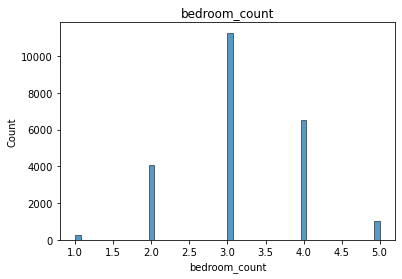

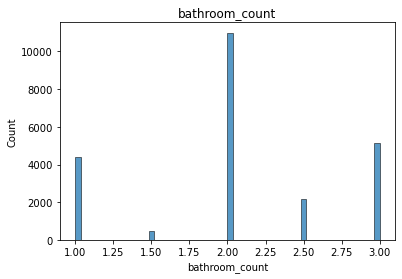

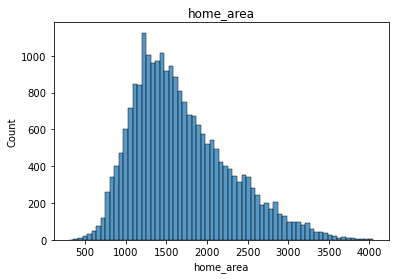

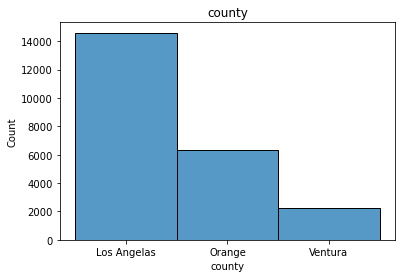

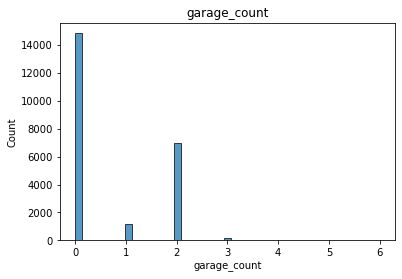

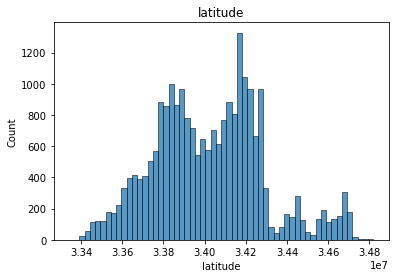

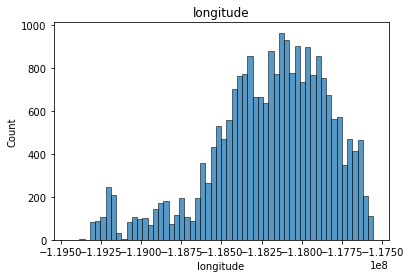

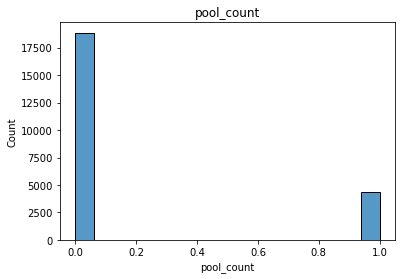

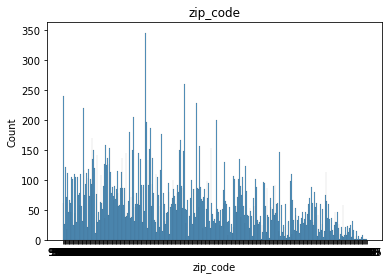

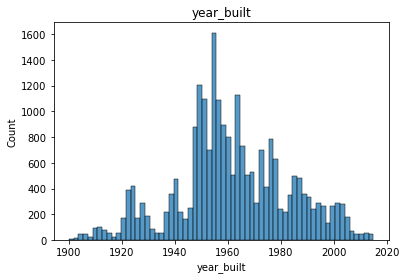

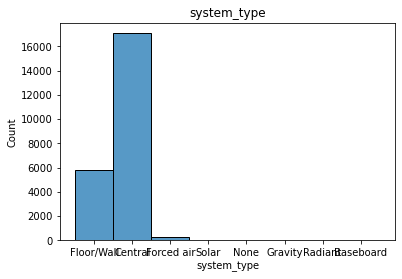

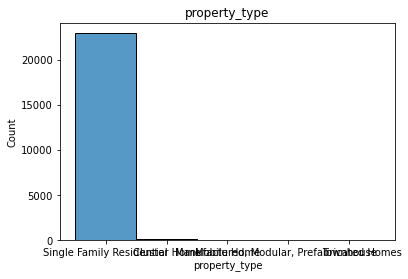

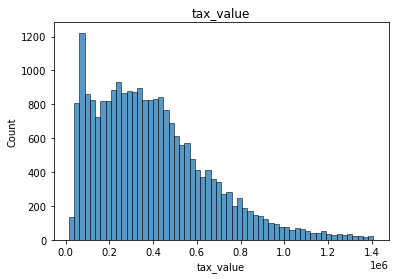

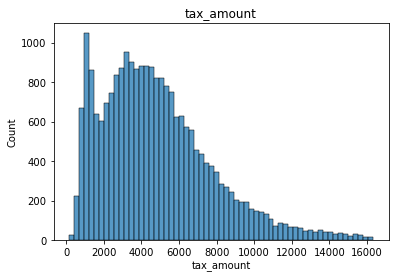

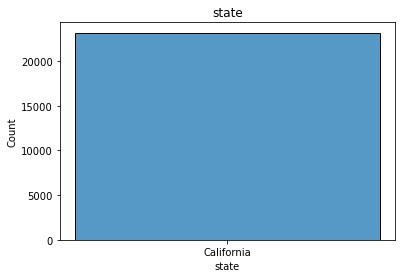

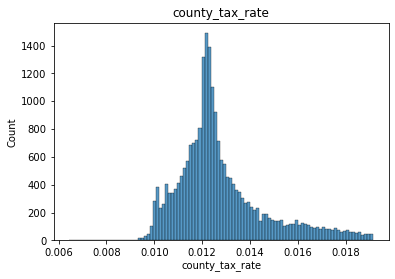

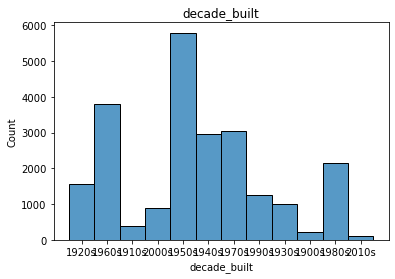

In [45]:
wrangle.get_dists(zillow)

Get the tax rate distributions

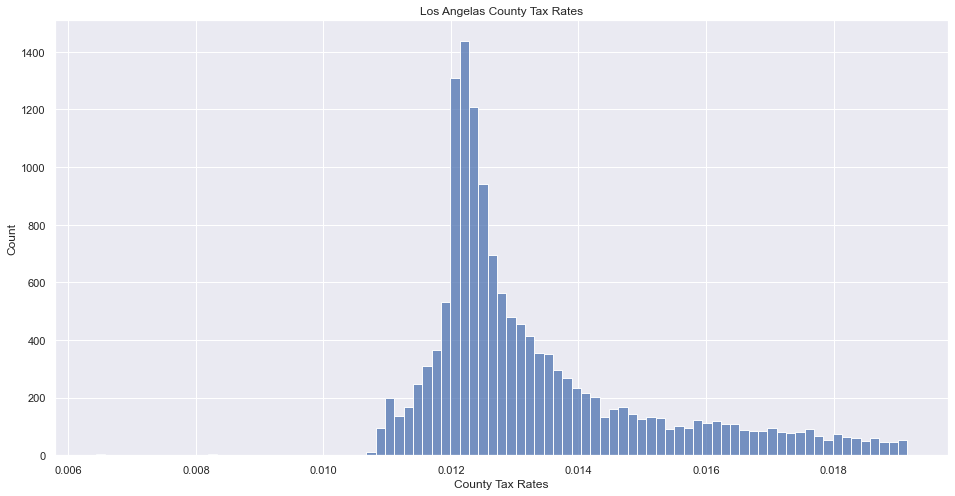

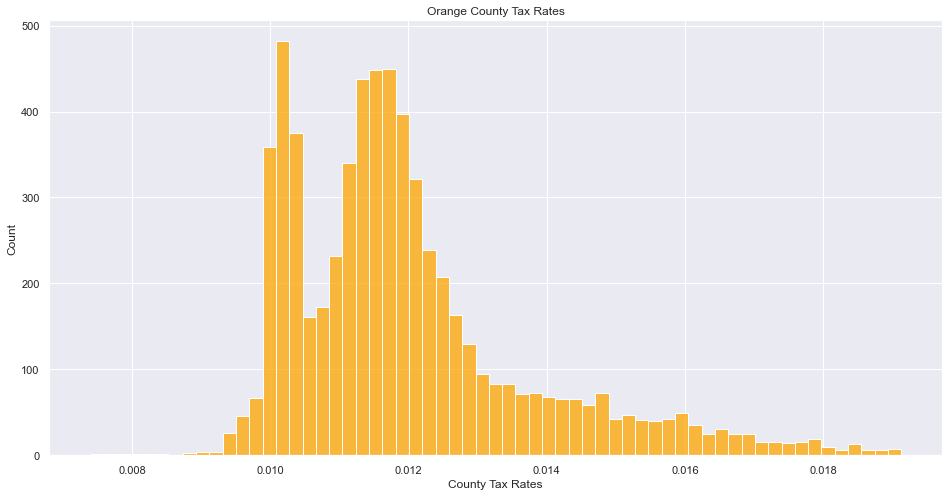

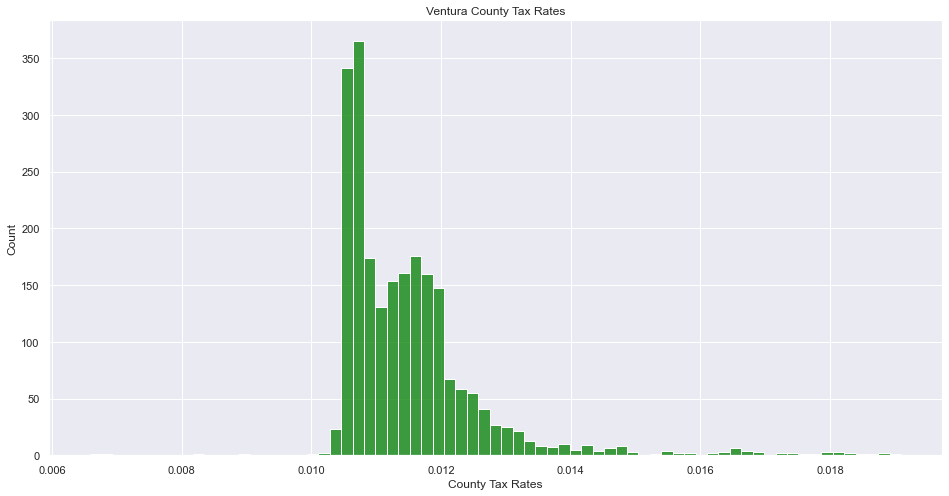

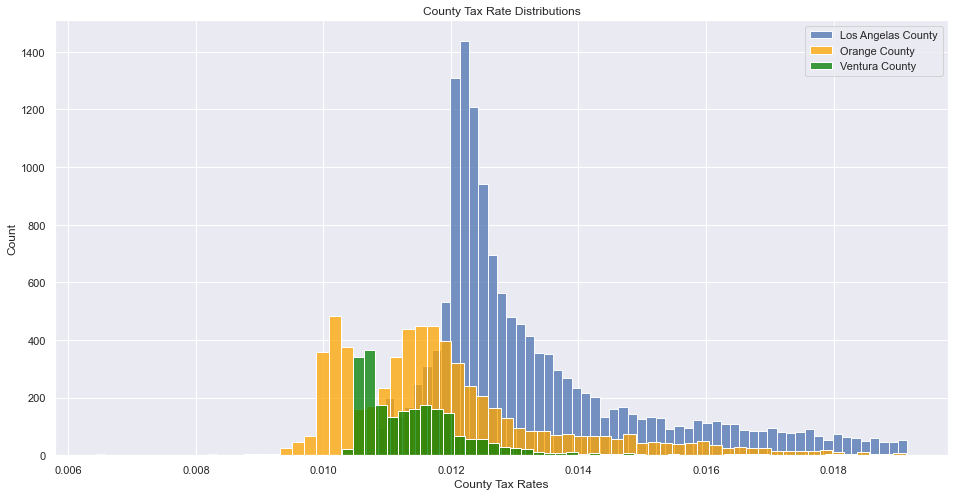

In [46]:
wrangle.get_tax_rate_dists(zillow)

Key Takeaways:
* Despite the added data, the distributions all appear to be the same as before.

### Explore the new Data

In [47]:
#Split data into train, validate, test data sets
train, validate, test = wrangle.train_validate_test_split(zillow)

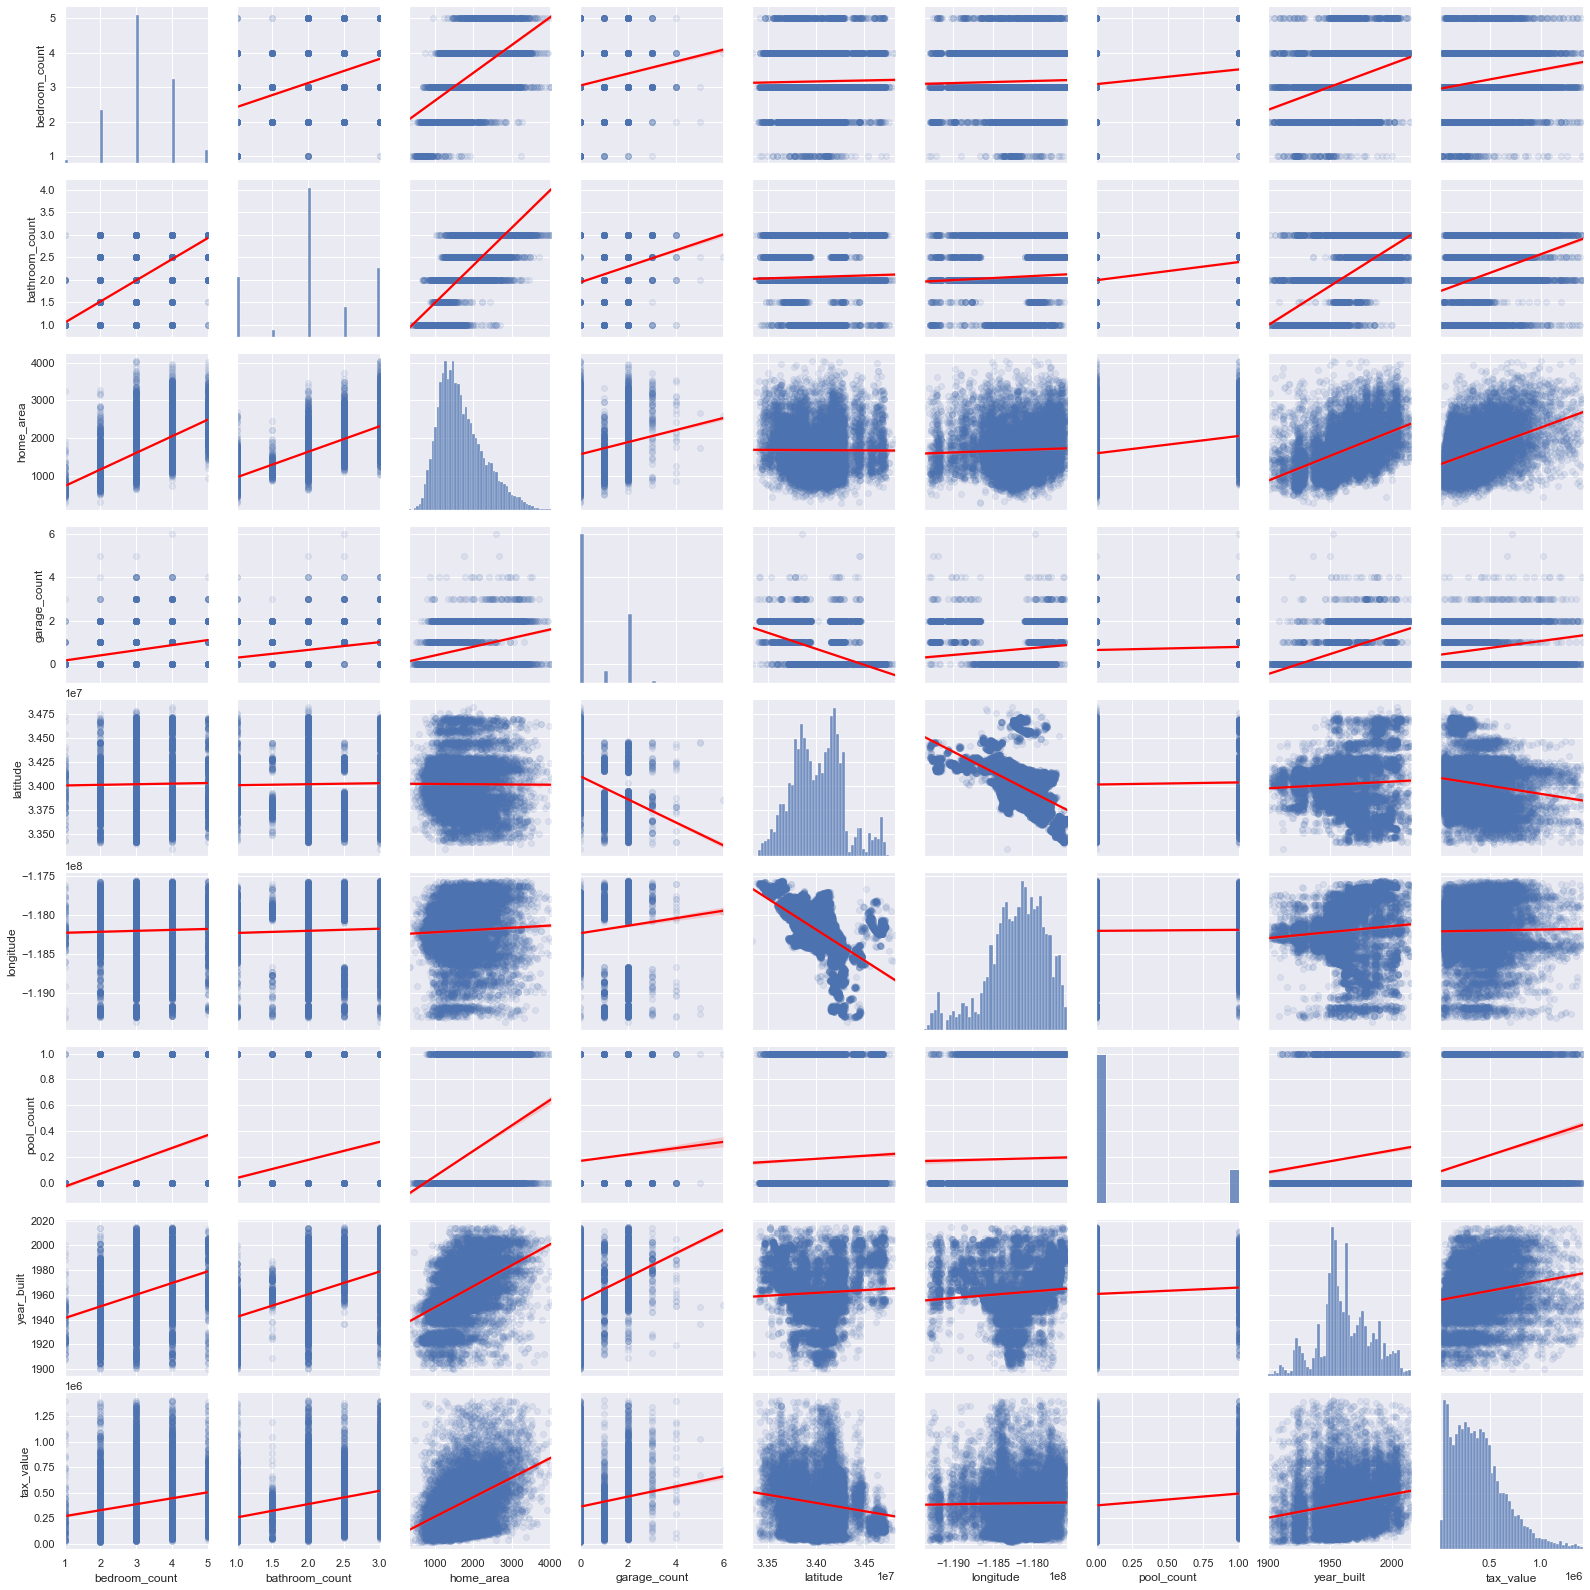

In [49]:
explore.get_pairwise_charts(train)

Key Takeaways:
* Again, home_area has the strongest positive correlation with the target variable, tax_value
* Some others to consider are garage_count, latitude, and year_built
* Latitude seems to have a negative correlation with tax_value, but longitude doesn't appear to have any relationship at all.

In [50]:
num_cols = train.select_dtypes('int').columns.append(train.select_dtypes('float').columns)

cat_cols = train.select_dtypes('object').columns

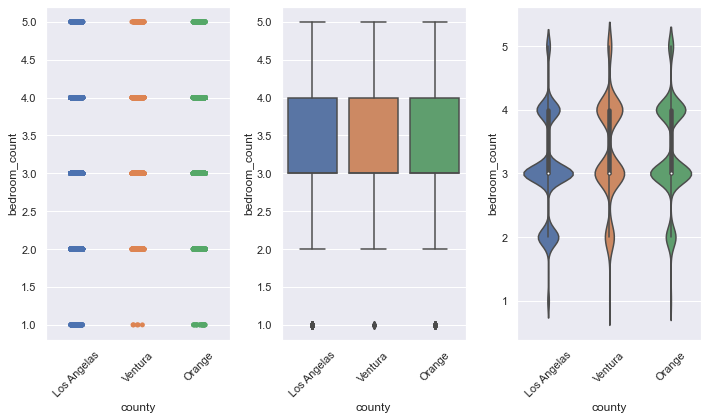

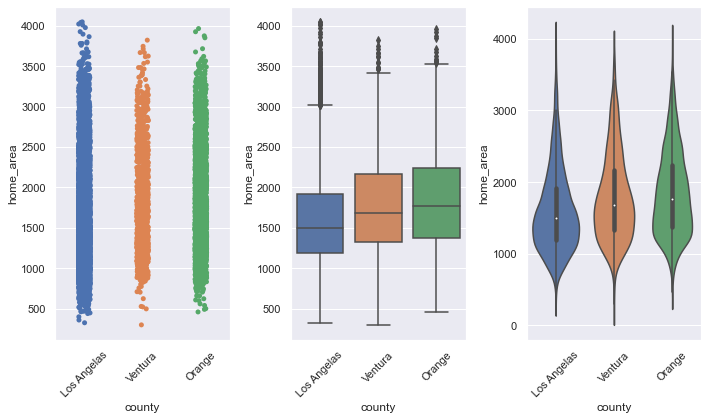

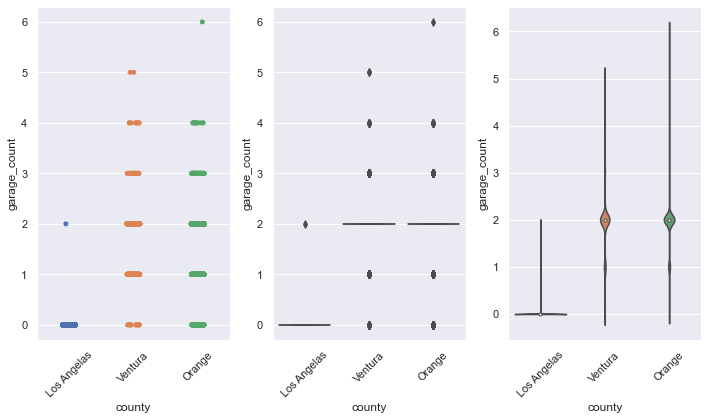

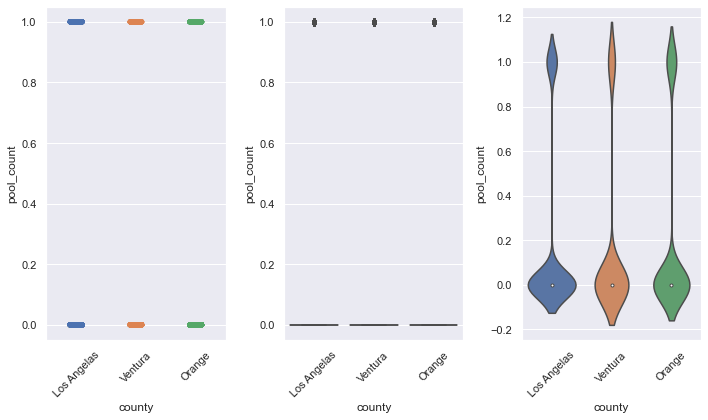

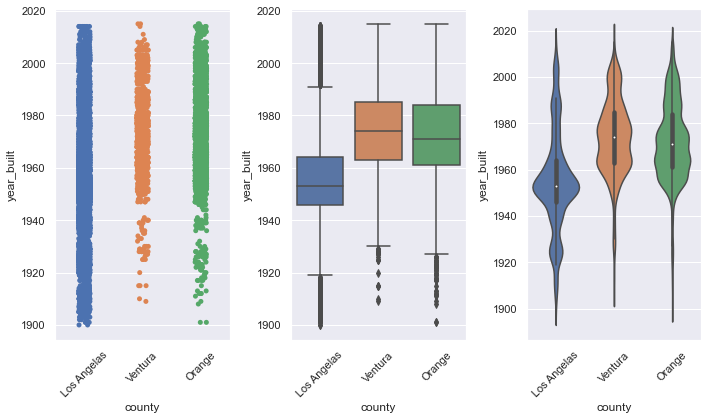

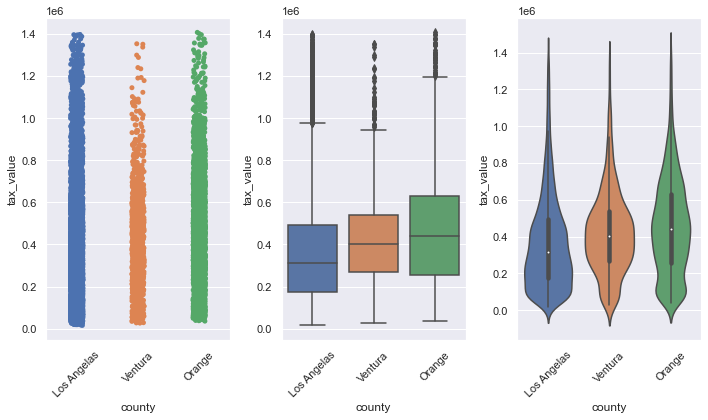

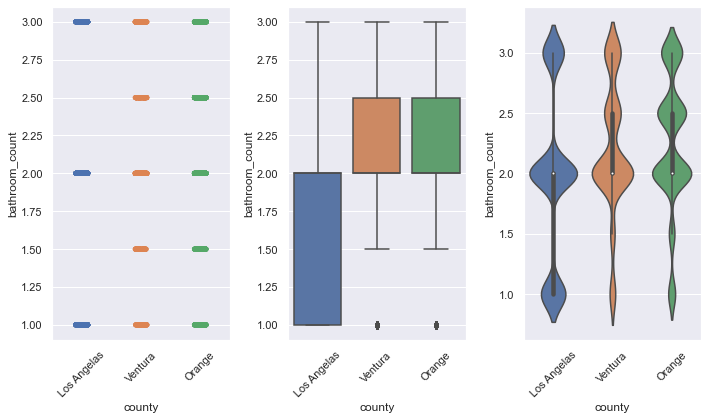

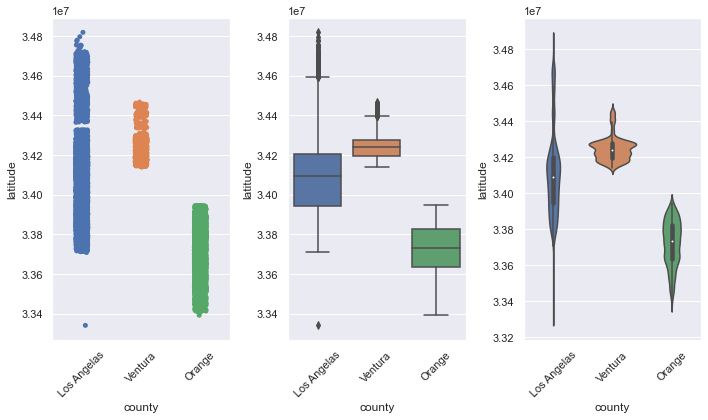

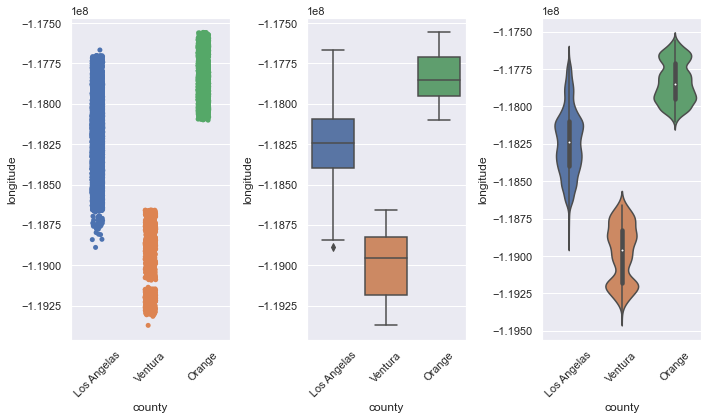

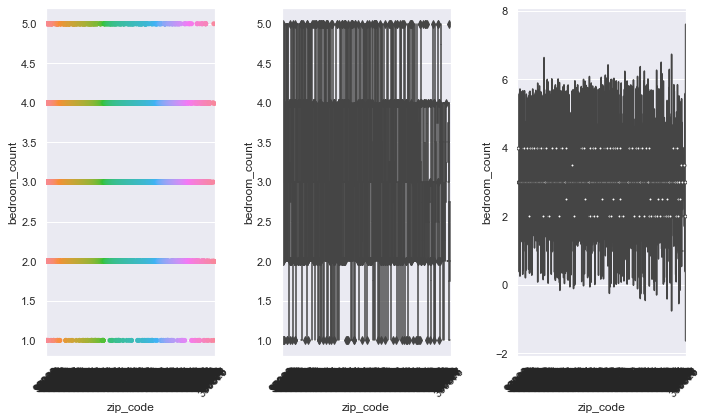

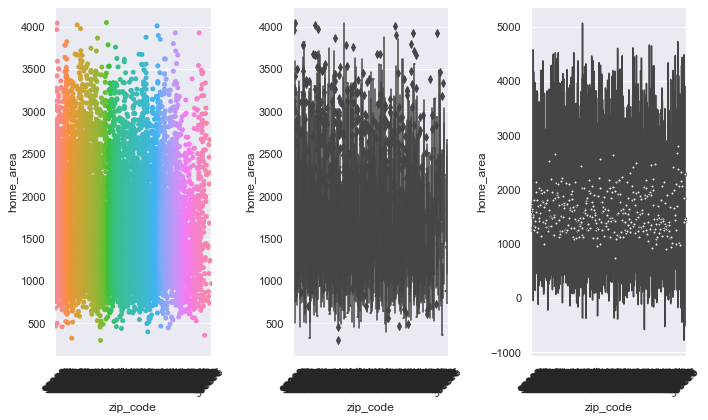

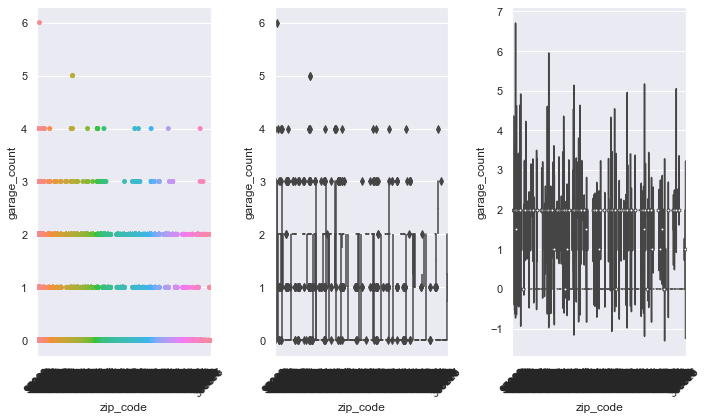

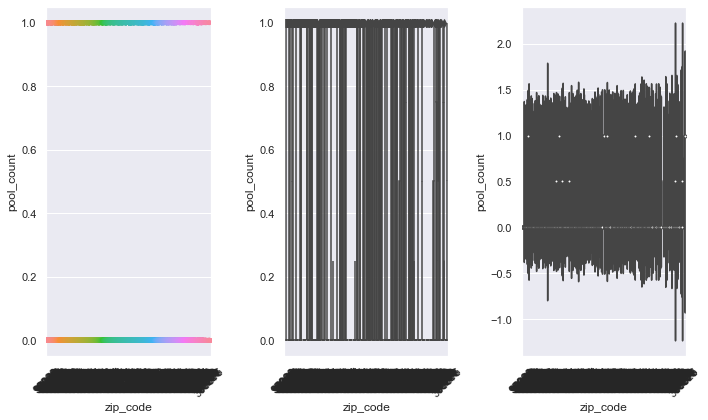

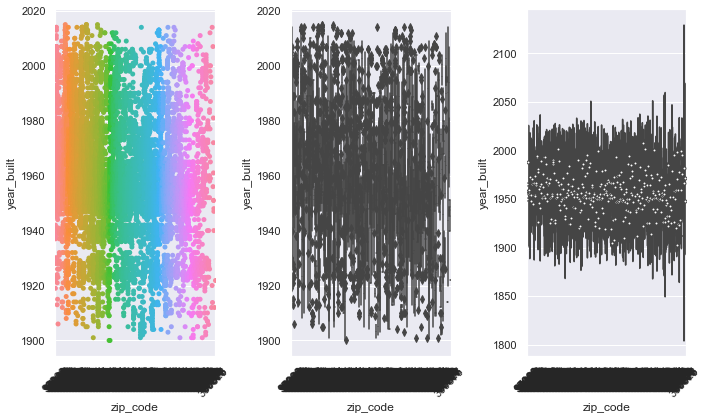

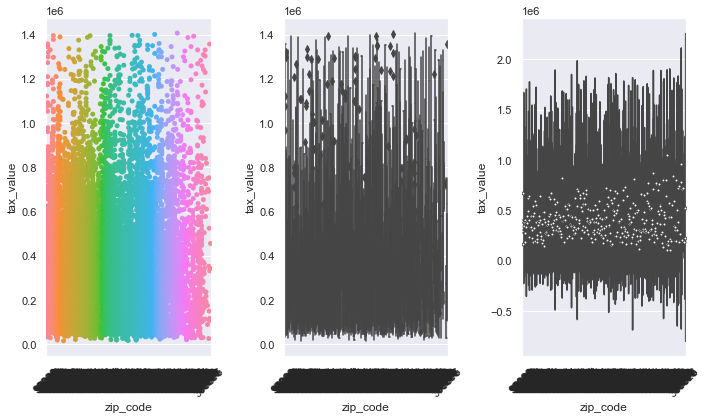

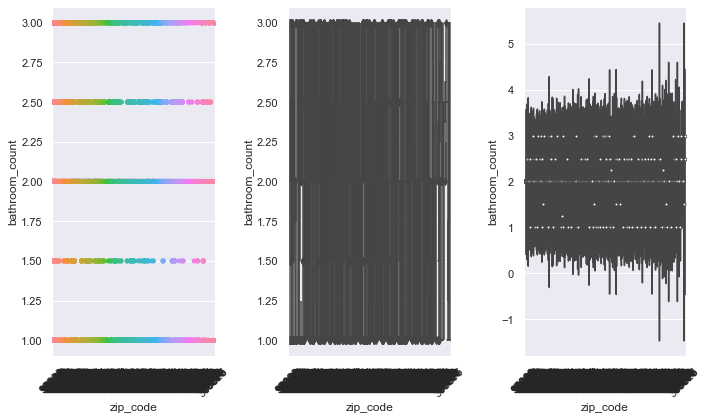

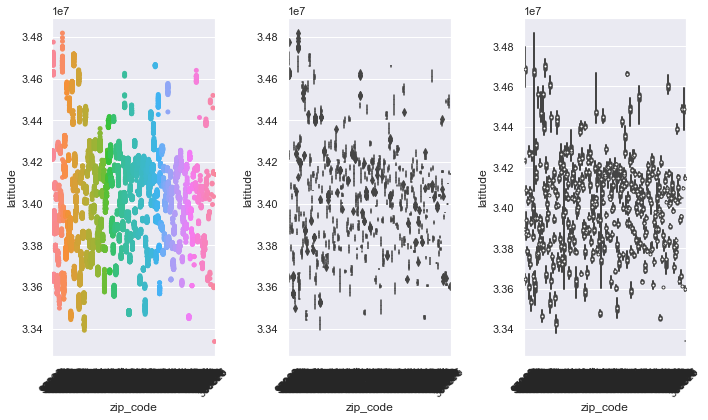

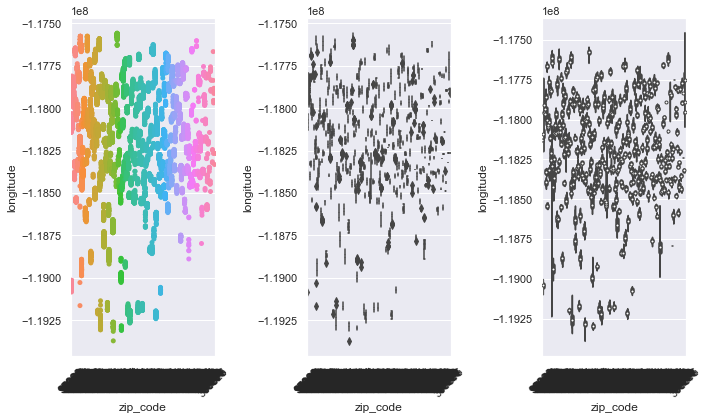

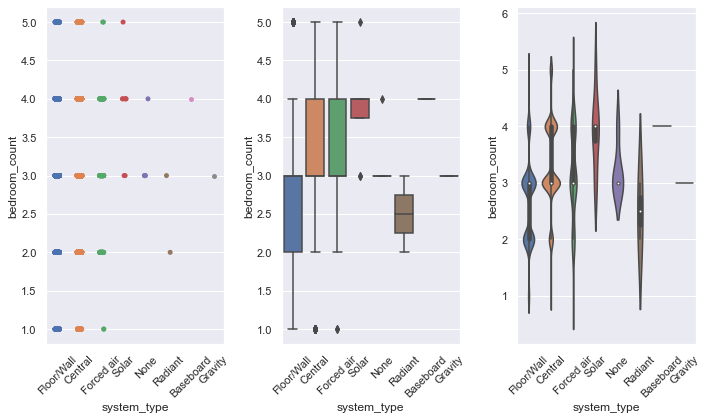

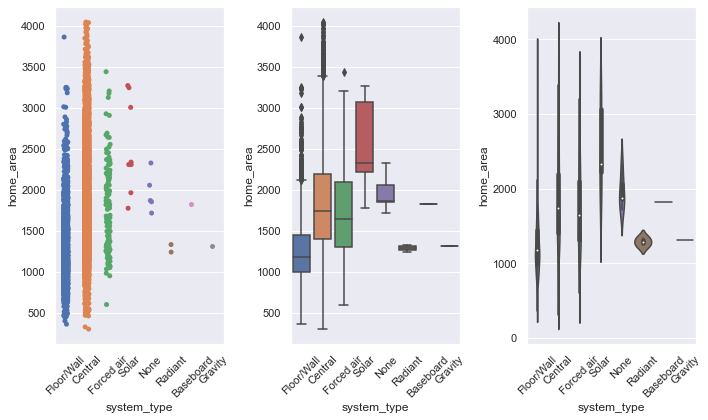

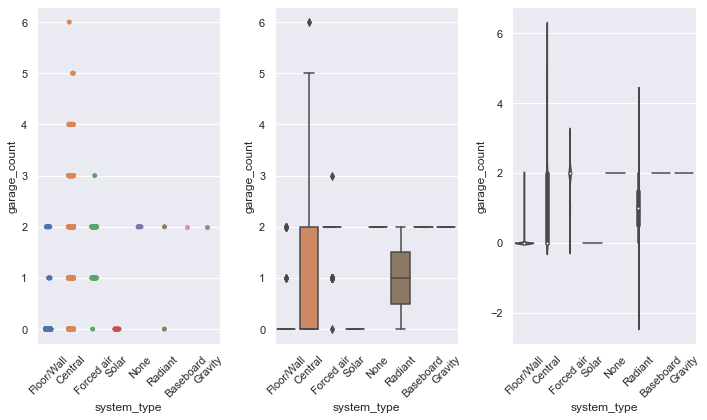

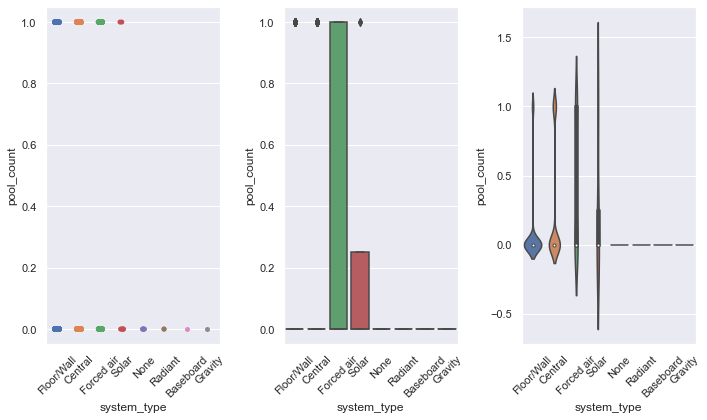

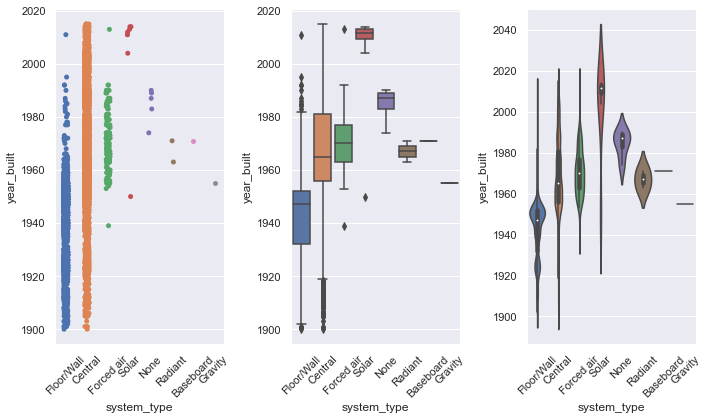

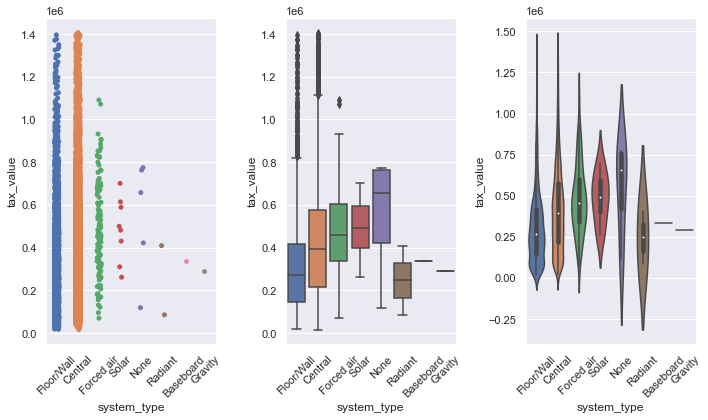

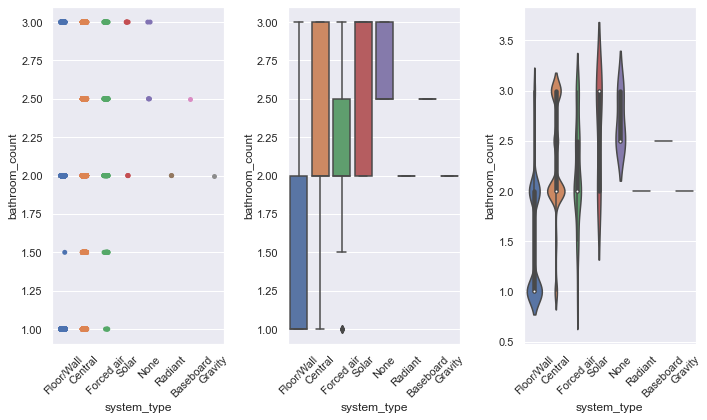

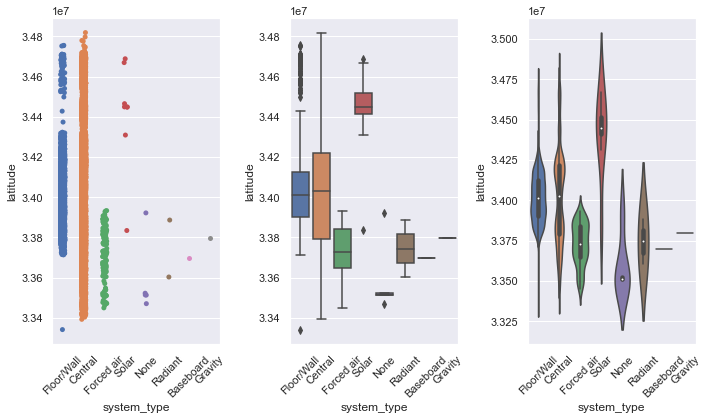

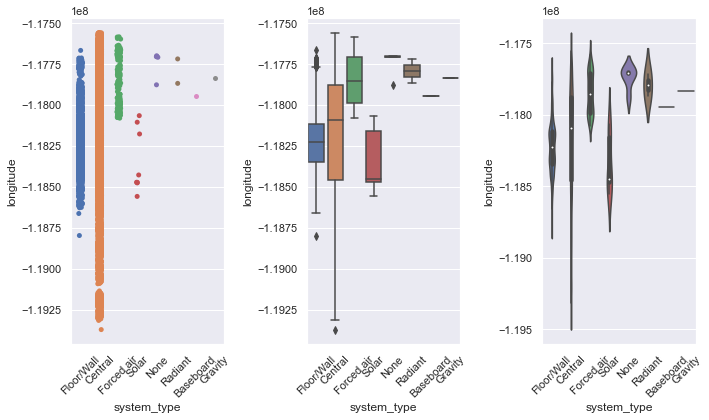

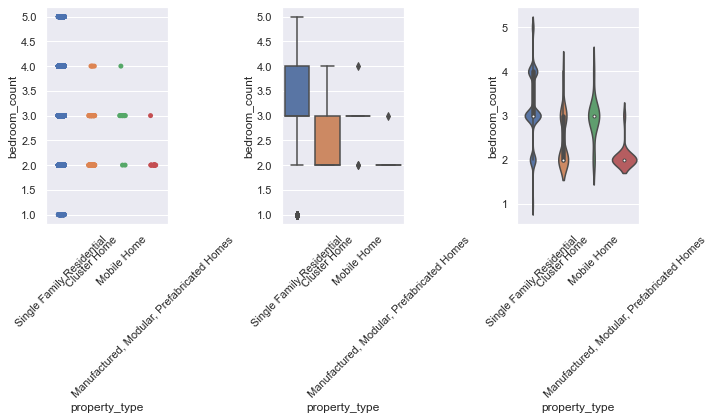

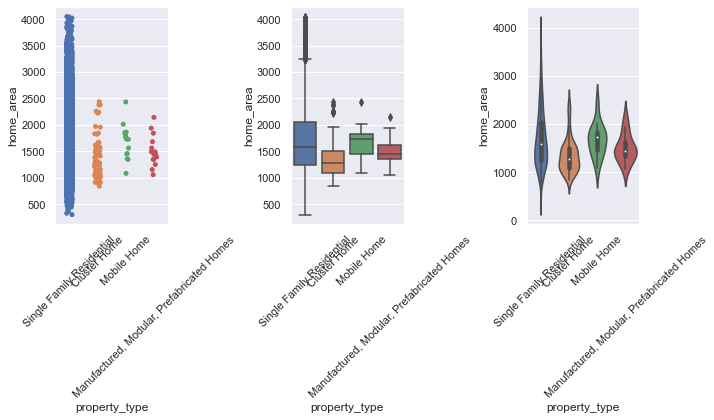

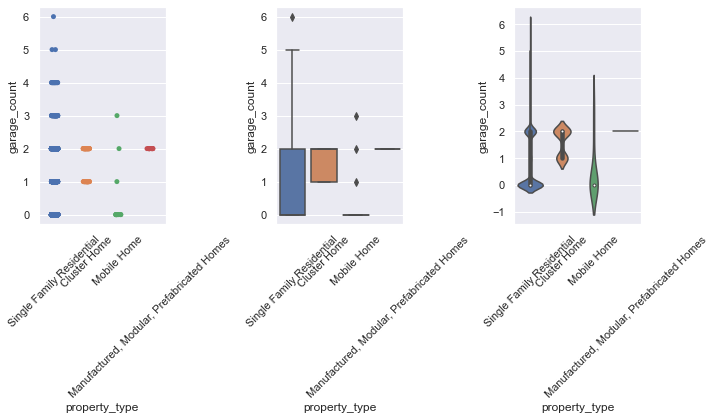

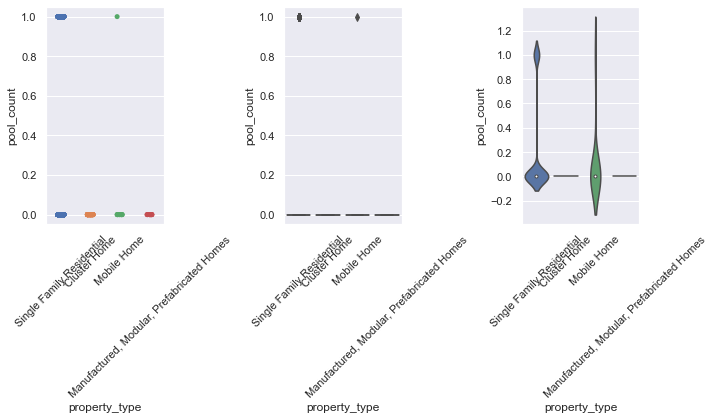

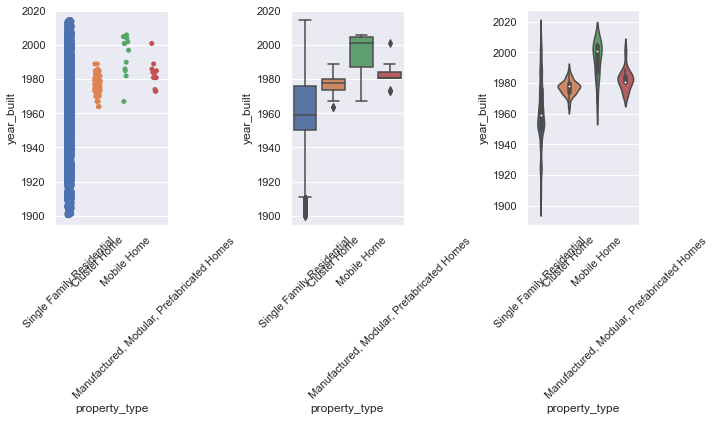

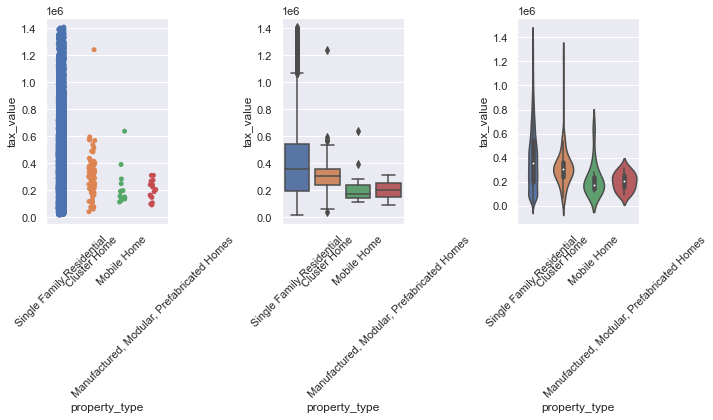

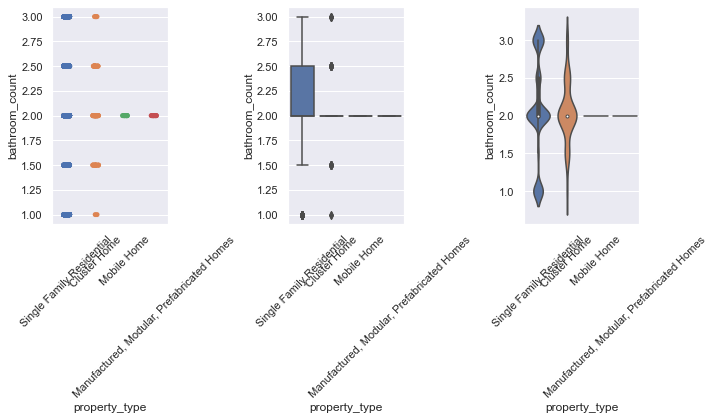

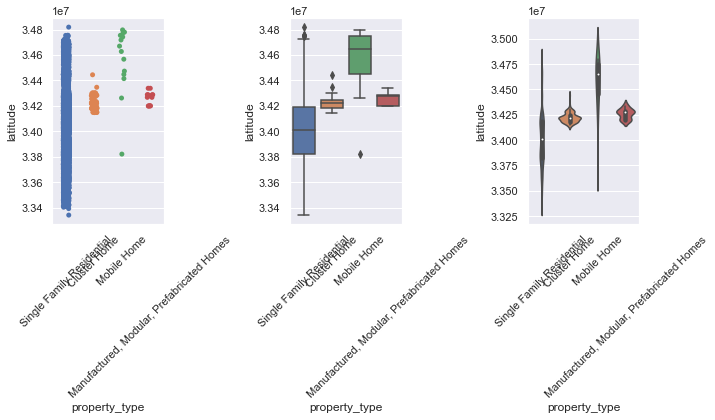

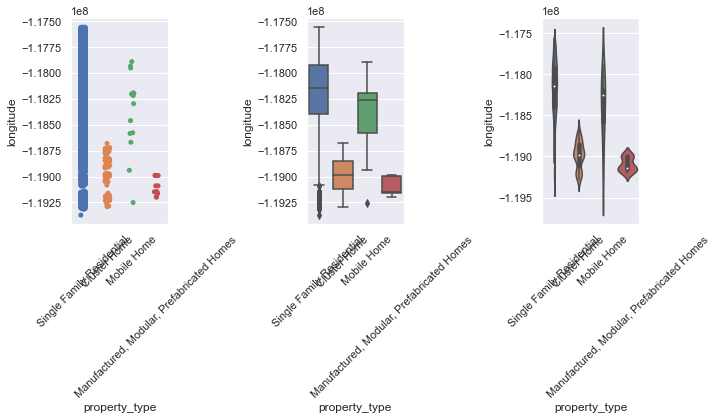

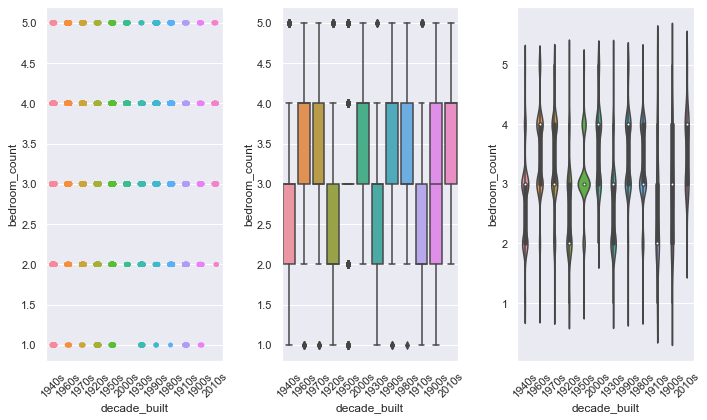

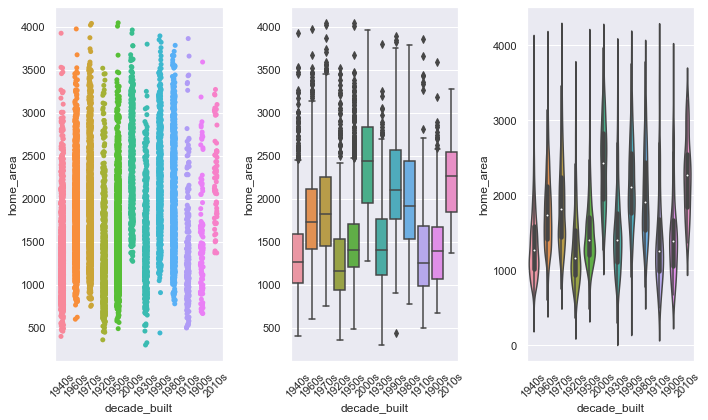

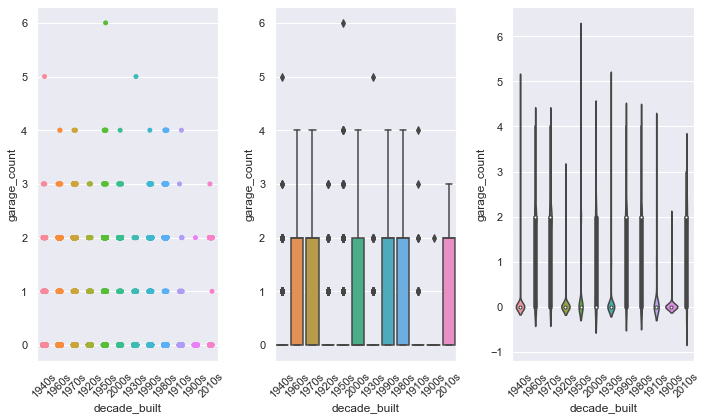

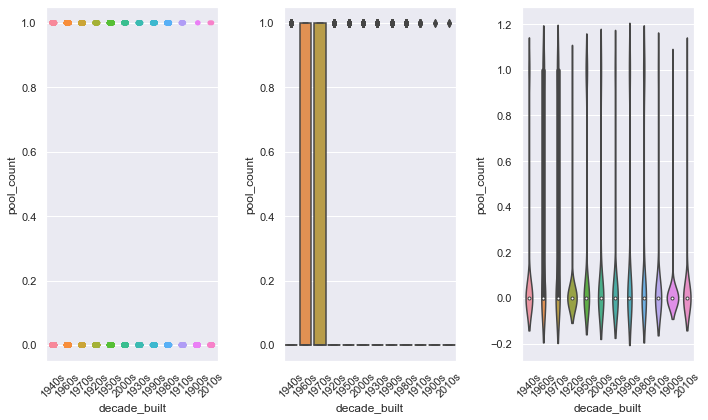

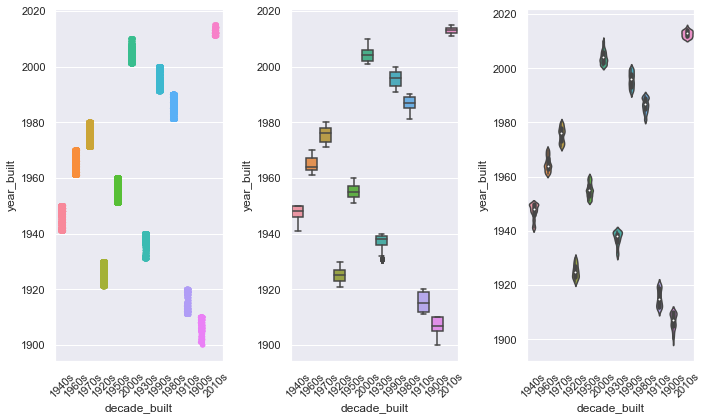

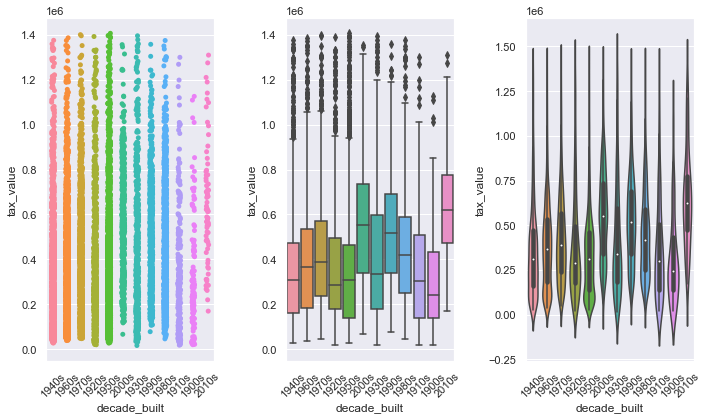

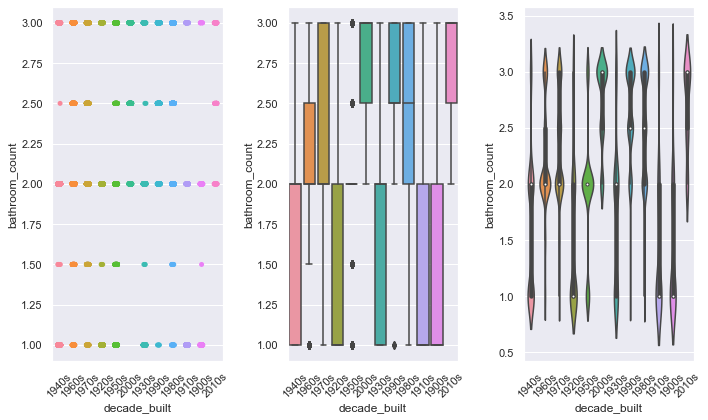

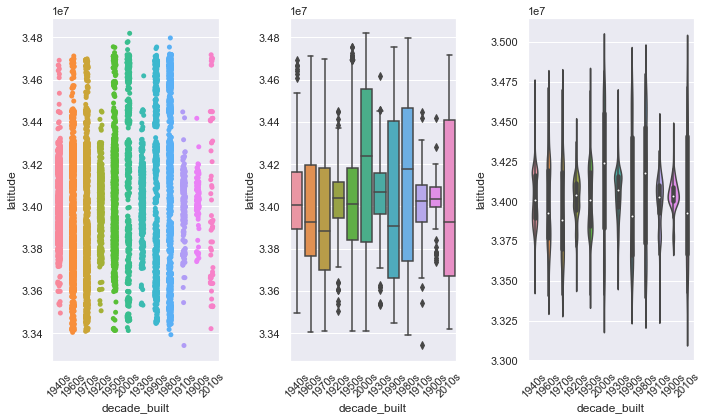

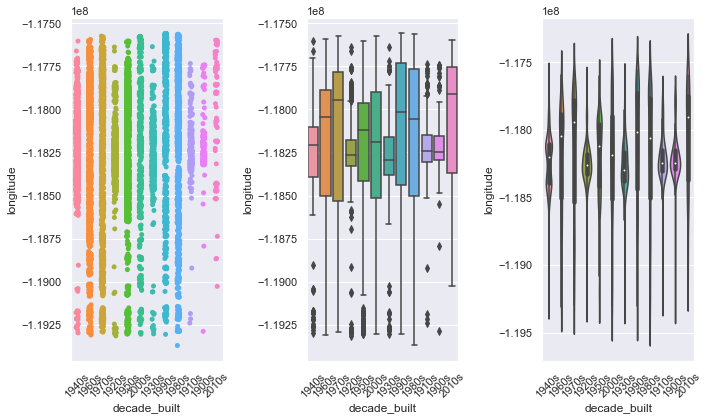

In [51]:
explore.plot_categorical_and_continuous_vars(train, cat_cols, num_cols)

Key Takeaways:
* Orange county seems to have the highest tax_values on average, but I think this is because Orange county also seems to have the largest homes on average.
* Both Orange and Ventura counties seem to have higher bathroom counts on average. Since they also have higher tax_value, maybe this is something worth exploring further.
* Ventura county differs greatly than the other two counties by longitude and latitude. Maybe a ratio of those two variables could be useful.
* County tax rate for Los Angelas county are much higher on average than those for Orange and Ventura counties, but tax_amount is less.
* Hard to get an idea on whether or not property_type has a relationship with tax_value from these graphs. Try a different one graphing tax_value, but give it a hue of property_type.
* Same as above, but for decade_built.

<Figure size 1152x576 with 0 Axes>

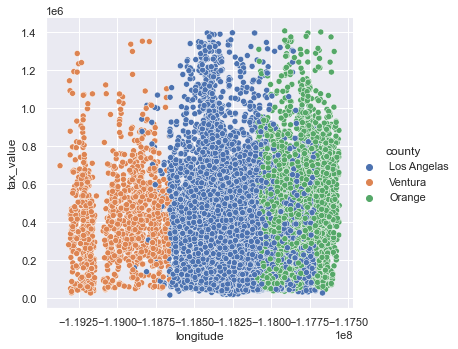

In [53]:
plt.figure(figsize=(16,8))
sns.relplot(x = 'longitude', y = 'tax_value', data = train, hue = 'county')
plt.show()

Is there a relationship between longitude and tax_value?

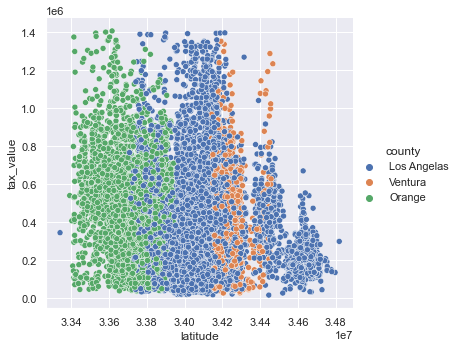

In [54]:
sns.relplot(x = 'latitude', y = 'tax_value', hue = 'county', data = train)
plt.show()

Latitude doesn't seem to be grouped as distinctly as longitude.

In [63]:
#Try making a new variable.
train['lat_long_ratio'] = train.latitude / train.longitude

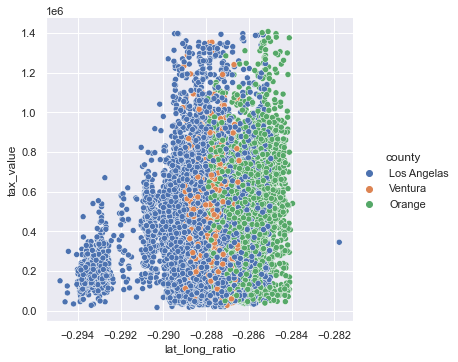

In [56]:
sns.relplot(x = 'lat_long_ratio', y = 'tax_value', hue = 'county', data = train)
plt.show()

There definitely seems to be a linear relationship here. I think it is worth testing in a hypothesis later.

In [57]:
#Try making a new variable.
train['lat_long_ratio'] = train.longitude - train.latitude

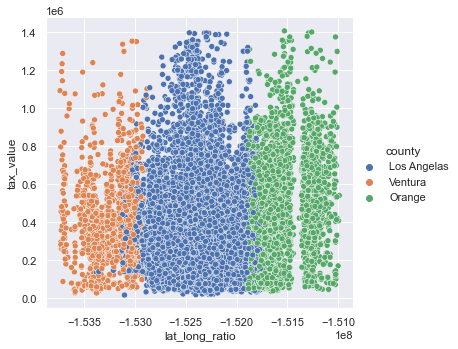

In [58]:
sns.relplot(x = 'lat_long_ratio', y = 'tax_value', hue = 'county', data = train)
plt.show()

These groupings are very distinctive for county, but don't really seem to have a relationship with tax_value.

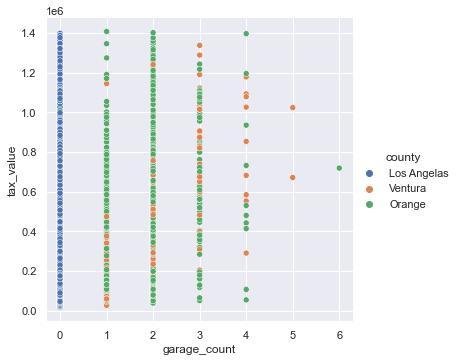

In [59]:
#Move on to garage_count
sns.relplot(x = 'garage_count', y = 'tax_value', hue = 'county', data = train)
plt.show()

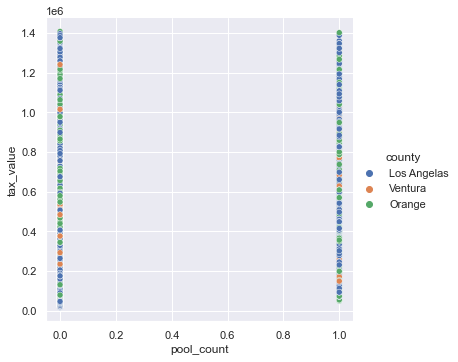

In [60]:
sns.relplot(x = 'pool_count', y = 'tax_value', hue = 'county', data = train)
plt.show()

Garage count and pool count seem to be useless.

In [61]:
#Try changing them to cat vars instead of numerical
train.garage_count = train.garage_count.astype(str)
train.pool_count = train.pool_count.astype(str)

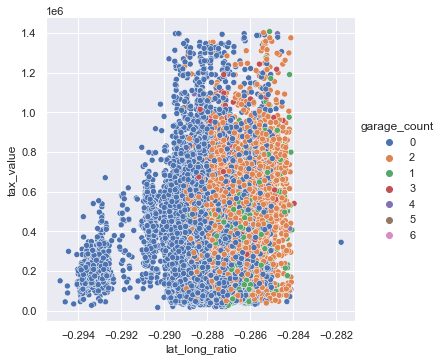

In [64]:
sns.relplot(x = 'lat_long_ratio', y = 'tax_value', hue = 'garage_count', data = train)
plt.show()

There does not seem to be a relationship between garage count and tax_value.

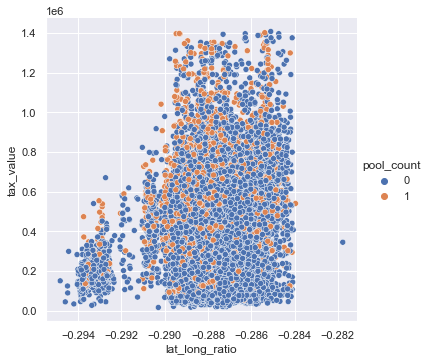

In [65]:
#Now try pool count
sns.relplot(x = 'lat_long_ratio', y = 'tax_value', hue = 'pool_count', data = train)
plt.show()

There may be a relationship here, but it appears to be pretty weak at best.

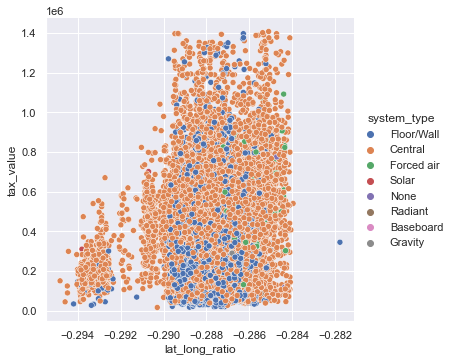

In [66]:
#Try system types
sns.relplot(x = 'lat_long_ratio', y = 'tax_value', hue = 'system_type', data = train)
plt.show()

Defnitely don't see a relationship here.

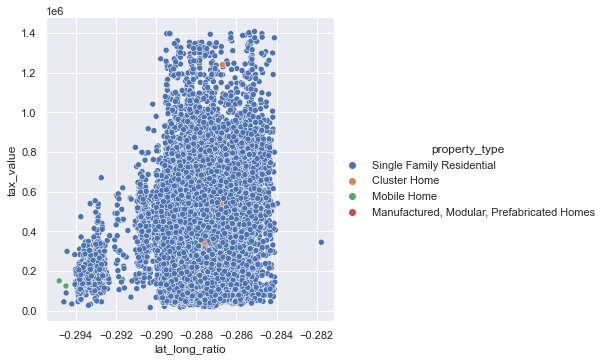

In [69]:
#Try property type
sns.relplot(x = 'lat_long_ratio', y = 'tax_value', hue = 'property_type', data = train)
plt.show()

In [70]:
#Make a new variable that holds a ratio of bedrooms to baths
train['bed_bath_ratio'] = train.bedroom_count.astype(float) / train.bathroom_count

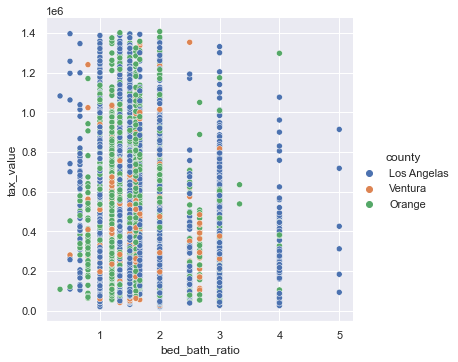

In [71]:
sns.relplot(x = 'bed_bath_ratio', y = 'tax_value', hue = 'county', data = train)
plt.show()

There may be a relationship here, but I'm not sure.

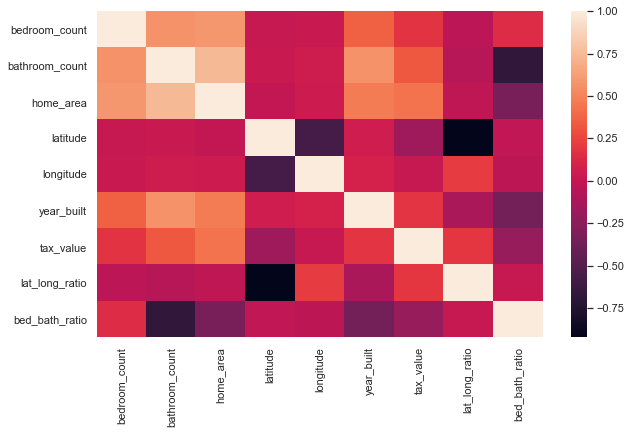

In [72]:
sns.heatmap(train.corr())
plt.show()

Again, there does not seem to be a relationship. Moving on.

In [73]:
import scipy.stats as stats

### Hypothesis Testing

__Hypothesis 1__

$H_0$: The average home_area of Orange County properties is <= The average home_area of Los Angelas and Ventura County properties.
    
$H_a$: The average home_area of Orange County properties is > The average home_area of Los Angelas and Ventura County properties.

In [74]:
alpha = 0.05

In [75]:
orange_county = train[train.county == 'Orange']
other_counties = train[train.county != 'Orange']

In [76]:
orange_county.tax_value.mean()

456492.3693744693

In [77]:
other_counties.tax_value.mean()

375087.643877659

In [78]:
t, p = stats.ttest_ind(orange_county.home_area, other_counties.home_area)
t, p

(18.807326797849576, 7.108573367877796e-78)

In [79]:
explore.is_significant(p, alpha)

p is less than alpha, so we reject the null hypothesis.


__Hypothesis 2__

$H_0$: The average tax_value of Orange County properties is <= The average tax_value of Los Angelas and Ventura County properties.
    
$H_a$: The average tax_value of Orange County properties is > The average tax_value of Los Angelas and Ventura County properties.

In [80]:
alpha = 0.05

In [81]:
t, p = stats.ttest_ind(orange_county.tax_value, other_counties.tax_value)
t,p

(16.00393152792933, 4.2156703800593073e-57)

In [82]:
explore.is_significant(p, alpha)

p is less than alpha, so we reject the null hypothesis.


__Hypothesis 3__

$H_0$: lat_long_ratio is not linearly correlated with tax_value.
    
$H_a$: lat_long_ratio is linearly correlated with tax_value.

In [83]:
alpha = 0.05

In [84]:
corr, p = stats.pearsonr(train.lat_long_ratio, train.tax_value)
corr, p

(0.18918918472554877, 6.82246861943447e-105)

In [85]:
explore.is_significant(p, alpha)

p is less than alpha, so we reject the null hypothesis.


__Hypothesis 4__

$H_0$: The average tax_value of Orange County properties is <= The average tax_value of Ventura County properties.
    
$H_a$: The average tax_value of Orange County properties is > The average tax_value of  Ventura County properties.

In [86]:
alpha = 0.05

In [87]:
ventura_county = train[train.county == 'Ventura']

In [88]:
t, p = stats.ttest_ind(orange_county.tax_value, ventura_county.tax_value)
t, p

(3.870668348669184, 0.00010998374118358553)

In [89]:
explore.is_significant(p, alpha)

p is less than alpha, so we reject the null hypothesis.


__Hypothesis 5__

$H_0$: The average tax_value of Orange County properties is <= The average tax_value of Los Angelas County properties.
    
$H_a$: The average tax_value of Orange County properties is > The average tax_value of Los Angelas County properties.

In [90]:
alpha = 0.05

In [91]:
la_county = train[train.county == 'Los Angelas']

In [92]:
t, p = stats.ttest_ind(orange_county.tax_value, la_county.tax_value)
t, p

(16.962193917964463, 8.985032982638827e-64)

In [93]:
explore.is_significant(p, alpha)

p is less than alpha, so we reject the null hypothesis.


__Hypothesis 6__

$H_0$: The average tax_value of Ventura County properties is <= The average tax_value of Los Angelas County properties.
    
$H_a$: The average tax_value of Ventura County properties is > The average tax_value of Los Angelas County properties.

In [94]:
alpha = 0.05

In [95]:
t, p = stats.ttest_ind(ventura_county.tax_value, la_county.tax_value)
t, p

(7.282622478092445, 3.5357545048785334e-13)

In [96]:
explore.is_significant(p, alpha)

p is less than alpha, so we reject the null hypothesis.


Key Takeaways:
* Since my statistical testing has shown that the average tax_values of each county is significantly different than each other, I think that 'county' would be a good feature for my model.
* I also think that lat_long_ratio would be a good feature.
* While not shown here, in my MVP I determined that bedroom_count is not as useful as bathroom_count. Therefore, in order to reduce the number of features my model has to deal with, I'm going to drop bedroom_count in favor of bathroom_count.

### Begin Modeling with New Features

In [97]:
#First drop the columns, you don't plan on using.
#Also, add lat_long_ratio to validate and test sets
validate['lat_long_ratio'] = validate.latitude / validate.longitude
test['lat_long_ratio'] = test.latitude / test.longitude

In [98]:
train = train[['bathroom_count', 'home_area', 'county', 'tax_value', 'lat_long_ratio']].copy()
validate = validate[['bathroom_count', 'home_area', 'county', 'tax_value', 'lat_long_ratio']].copy()
test = test[['bathroom_count', 'home_area', 'county', 'tax_value', 'lat_long_ratio']].copy()
train.head()

bathroom_count  home_area       county  tax_value  lat_long_ratio
28340             1.0        680  Los Angelas     194242       -0.286878
20068             2.0       1386      Ventura     213604       -0.287546
7629              2.0       1176  Los Angelas      51119       -0.293832
18738             1.0       1115       Orange     201432       -0.285292
5967              2.0       1629       Orange      69687       -0.287791

In [ ]:
#Split into X and y groups
#Create dummy variables